## AVS Kaggle Competition

Links to Kaggle Comp Data: https://www.kaggle.com/c/acquire-valued-shoppers-challenge/data

#### Import Libraries

In [1]:
# basics imports

import os

import pandas as pd
import numpy as np


In [2]:
#S3
from boto.s3.connection import S3Connection
from IPython.parallel import Client

In [2]:
#plotting libraries and setting defaults

%matplotlib inline

import seaborn as sns
from seaborn import plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

### Launch EC2 instance

#### Load data
Ref 1: Lab '04 - Starcluster' 
Ref 2: Lab '17-ScalineOut' 

In [5]:
credentials = pd.read_csv('/home/centos/certificates/credentials.csv')

In [6]:
aws_id = credentials['Access Key Id'][0]
#aws_id

In [7]:
aws_key = credentials['Secret Access Key'][0]
#aws_key

In [8]:
#load S3
s3conn = S3Connection( aws_id , aws_key )
#s3conn = S3Connection?

In [9]:
#s3conn.get_bucket?

In [10]:
bucket = s3conn.get_bucket('avs-kaggle-data')

#### Load 'offers_df'
This code works ==> this technique will work with new, larger datasets on powerful EC2 instance

In [11]:
offers_keys = bucket.get_all_keys(prefix='offers')
len( offers_keys)

1

In [12]:
offers_keys[0].get_contents_to_filename('offers.csv')

In [13]:
offers_df = pd.read_csv('offers.csv')
offers_df.head(3)

,offer,category,quantity,company,offervalue,brand
0,1190530,9115,1,108500080,5.00,93904
1,1194044,9909,1,107127979,1.00,6732
2,1197502,3203,1,106414464,0.75,13474


In [14]:
offers_df.shape

(37, 6)

#### Load 'train_hist_df'
This file is 6MB and timed out on laptop ==> need to launch in starcluster

In [15]:
train_hist_keys = bucket.get_all_keys(prefix='trainHistory')
len( train_hist_keys)

1

In [16]:
train_hist_keys[0].get_contents_to_filename('trainHistory.csv')

In [17]:
train_hist_df = pd.read_csv('trainHistory.csv')
train_hist_df.head(3)

,id,chain,offer,market,repeattrips,repeater,offerdate
0,86246,205,1208251,34,5,t,2013-04-24
1,86252,205,1197502,34,16,t,2013-03-27
2,12682470,18,1197502,11,0,f,2013-03-28


In [18]:
train_hist_df.shape

(160057, 7)

#### Load 'test_hist_df'

In [35]:
test_hist_keys = bucket.get_all_keys(prefix='testHistory')
len( test_hist_keys)

1

In [37]:
test_hist_keys[0].get_contents_to_filename('testHistory.csv')

In [38]:
test_hist_df = pd.read_csv('testHistory.csv')
test_hist_df.head(3)

,id,chain,offer,market,offerdate
0,12262064,95,1219903,39,2013-06-27
1,12277270,95,1221658,39,2013-06-23
2,12332190,95,1213242,39,2013-06-15


In [39]:
test_hist_df.shape

(151484, 5)

#### Load 'transactions_df'

In [35]:
trans_keys = bucket.get_all_keys(prefix='transactions.csv')
len( trans_keys)

1

In [36]:
trans_keys

[<Key: avs-kaggle-data,transactions.csv.gz>]

In [37]:
#note: this can take a few minutes
trans_keys[0].get_contents_to_filename('transactions.csv.gz')

In [38]:
trans_keys

[<Key: avs-kaggle-data,transactions.csv.gz>]

In [1]:
import pandas as pd
trans_df = pd.read_csv('transactions.csv.gz', compression='gzip', low_memory=True) 
trans_df.head(3)

#memory error, even with r3.2xlarge (60gb RAM)

MemoryError: 

In [ ]:
trans_df.shape

In [41]:
f = gzip.open('transactions.csv.gz', 'rb')

In [42]:
file_content = f.read()

MemoryError: 

In [40]:
import gzip
#https://docs.python.org/2/library/gzip.html

#### Reduce 'transactions_df to only transaction where category included in (at least 1) offer (1.6gb)
http://www.kaggle.com/c/acquire-valued-shoppers-challenge/forums/t/7666/getting-started-data-reduction/

#### Load 'transactions_sample_df'
transactions_sample is a reduced set of customers (all transactions for each customer): <br/>
https://www.kaggle.com/c/acquire-valued-shoppers-challenge/forums/t/7659/sample-of-transaction-data/41783

In [19]:
trans_sample_keys = bucket.get_all_keys(prefix='transactions-sample')
len( trans_sample_keys)

1

In [20]:
trans_sample_keys[0].get_contents_to_filename('transactions-sample.csv')

In [21]:
trans_sample_df = pd.read_csv('transactions-sample.csv')
trans_sample_df.head(3)

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99


In [22]:
trans_sample_df.shape

(27842, 11)

### Explore Datasets

#### Joining DF

#### Train DF

In [45]:
train_hist_df.shape

(160057, 7)

In [46]:
train_hist_df.head()

,id,chain,offer,market,repeattrips,repeater,offerdate
0,86246,205,1208251,34,5,t,2013-04-24
1,86252,205,1197502,34,16,t,2013-03-27
2,12682470,18,1197502,11,0,f,2013-03-28
3,12996040,15,1197502,9,0,f,2013-03-25
4,13089312,15,1204821,9,0,f,2013-04-01


In [47]:
train_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160057 entries, 0 to 160056
Data columns (total 7 columns):
id             160057 non-null int64
chain          160057 non-null int64
offer          160057 non-null int64
market         160057 non-null int64
repeattrips    160057 non-null int64
repeater       160057 non-null object
offerdate      160057 non-null object
dtypes: int64(5), object(2)
memory usage: 9.8+ MB


In [48]:
train_hist_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,160057,1.869324e+09,1.570833e+09,86246,498182177,767486408,3285612741,4809911000
chain,160057,1.268103e+02,1.279343e+02,2,21,96,165,526
offer,160057,1.201984e+06,4.705531e+03,1194044,1197502,1200581,1208251,1208503
market,160057,1.995060e+01,1.909901e+01,1,10,14,24,96
repeattrips,160057,6.563349e-01,6.786516e+00,0,0,0,1,2124


In [91]:
len( pd.value_counts(train_hist_df['chain']))

130

In [92]:
len( pd.value_counts(train_hist_df['offer']))

24

In [93]:
len( pd.value_counts(train_hist_df['market']))

34

In [94]:
len( pd.value_counts(train_hist_df['repeattrips']))

56

#### Offers DF

In [33]:
offers_df.shape

(37, 6)

In [50]:
print offers_df

      offer  category  quantity     company  offervalue   brand
0   1190530      9115         1   108500080        5.00   93904
1   1194044      9909         1   107127979        1.00    6732
2   1197502      3203         1   106414464        0.75   13474
3   1198271      5558         1   107120272        1.50    5072
4   1198272      5558         1   107120272        1.50    5072
5   1198273      5558         1   107120272        1.50    5072
6   1198274      5558         1   107120272        1.50    5072
7   1198275      5558         1   107120272        1.50    5072
8   1199256      4401         1   105100050        2.00   13791
9   1199258      4401         1   105100050        2.00   13791
10  1200578      1703         1   104460040        1.50    7668
11  1200579      1703         1   104460040        1.50    7668
12  1200581      1726         1   104460040        1.25    7668
13  1200582      1726         1   104460040        1.25    7668
14  1200584      3504         1   104460

In [85]:
pd.value_counts(offers_df['offervalue'])
#majority of offers are between $1-2, with the vast majority being $1.50

1.50    19
2.00     6
1.00     5
1.25     3
3.00     2
5.00     1
0.75     1
dtype: int64

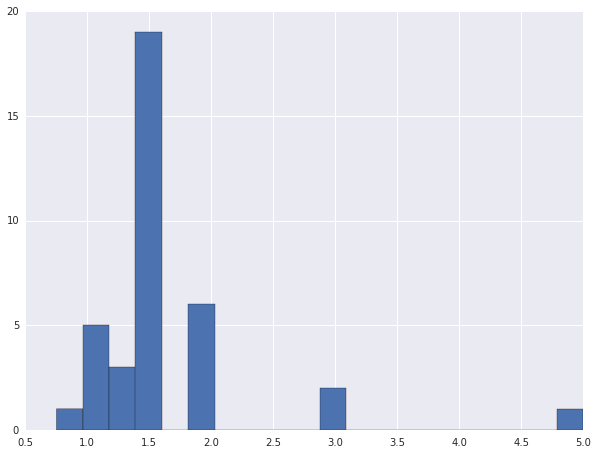

In [89]:
offers_df.offervalue.hist(bins=20)

In [73]:
pd.value_counts(offers_df['offervalue'])

1.50    19
2.00     6
1.00     5
1.25     3
3.00     2
5.00     1
0.75     1
dtype: int64

In [68]:
#offers_df.groupby(['category']).transform('count')
pd.value_counts(offers_df['category'])

5558    5
7205    5
1726    2
1703    2
2202    2
6202    2
4517    2
799     2
4401    2
5619    2
9909    2
5616    1
3504    1
9115    1
3509    1
706     1
2119    1
3203    1
5122    1
5824    1
dtype: int64

In [69]:
pd.value_counts(offers_df['company'])

104460040     7
103700030     5
107120272     5
107717272     2
105450050     2
1087744888    2
105100050     2
1076211171    2
1089520383    1
108079383     1
105190050     1
103320030     1
107106878     1
104127141     1
107127979     1
108500080     1
104610040     1
106414464     1
dtype: int64

In [72]:
pd.value_counts(offers_df['brand'])

4294      5
5072      5
7668      5
102504    2
13791     2
17286     2
1322      2
3718      2
64486     2
13474     1
28840     1
15889     1
93904     1
6926      1
26189     1
6732      1
17311     1
875       1
26456     1
dtype: int64

#### Transaction-Sample DF

In [34]:
trans_sample_df.shape

(27842, 11)

In [36]:
#no null values
trans_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27842 entries, 0 to 27841
Data columns (total 11 columns):
id                  27842 non-null int64
chain               27842 non-null int64
dept                27842 non-null int64
category            27842 non-null int64
company             27842 non-null int64
brand               27842 non-null int64
date                27842 non-null object
productsize         27842 non-null float64
productmeasure      27618 non-null object
purchasequantity    27842 non-null int64
purchaseamount      27842 non-null float64
dtypes: float64(2), int64(7), object(2)
memory usage: 2.5+ MB


In [49]:
#only a few customer ids
len( pd.value_counts(trans_sample_df['id']))

5

In [50]:
len( pd.value_counts(trans_sample_df['chain']))

2

In [51]:
len( pd.value_counts(trans_sample_df['dept']))

82

In [52]:
len( pd.value_counts(trans_sample_df['category']))

661

In [53]:
len( pd.value_counts(trans_sample_df['company']))

1355

In [54]:
len( pd.value_counts(trans_sample_df['brand']))

1805

In [55]:
len( pd.value_counts(trans_sample_df['productsize']))

653

In [57]:
len( pd.value_counts(trans_sample_df['purchasequantity']))

24

In [56]:
len( pd.value_counts(trans_sample_df['purchaseamount']))

1514

In [48]:
pd.DataFrame( trans_sample_df.groupby(['id','chain'])['purchasequantity','purchaseamount'].agg('sum') )

,,purchasequantity,purchaseamount
id,chain,,
86246,205,17333,52828.12
86252,205,17604,53592.90
12262064,95,1262,4118.18
12277270,95,1638,8085.44
12332190,95,891,3587.71


In [43]:
trans_sample_df.describe()

,id,chain,dept,category,company,brand,productsize,purchasequantity,purchaseamount
count,27842.000000,27842.000000,27842.000000,27842.000000,2.784200e+04,27842.000000,27842.000000,27842.000000,27842.000000
mean,1464518.304432,192.570577,40.320703,4046.298829,2.179135e+08,16964.997881,29.308435,1.390992,4.389496
std,3861686.310634,34.825128,26.391795,2643.541796,4.781015e+08,16189.953805,49.739271,1.087621,4.933723
min,86246.000000,95.000000,0.000000,0.000000,1.000000e+04,0.000000,0.000000,-1.000000,-9.680000
25%,86246.000000,205.000000,21.000000,2103.000000,1.027000e+08,6732.000000,7.000000,1.000000,1.980000
50%,86252.000000,205.000000,36.000000,3612.000000,1.041303e+08,13310.000000,14.750000,1.000000,3.190000
75%,86252.000000,205.000000,58.000000,5828.000000,1.072471e+08,19713.000000,26.500000,1.000000,4.990000
max,12332190.000000,205.000000,99.000000,9909.000000,1.097815e+10,108338.000000,960.000000,39.000000,164.900000


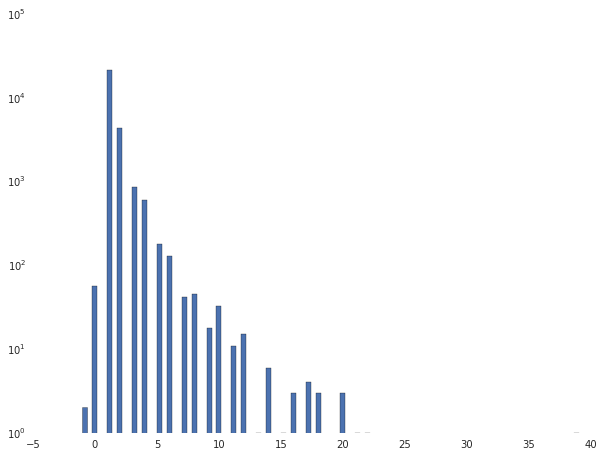

In [63]:
#trans_sample_df.purchasequantity.hist()
fig, ax = plt.subplots()
trans_sample_df.purchasequantity.hist( ax=ax, bins=100)
ax.set_yscale('log')

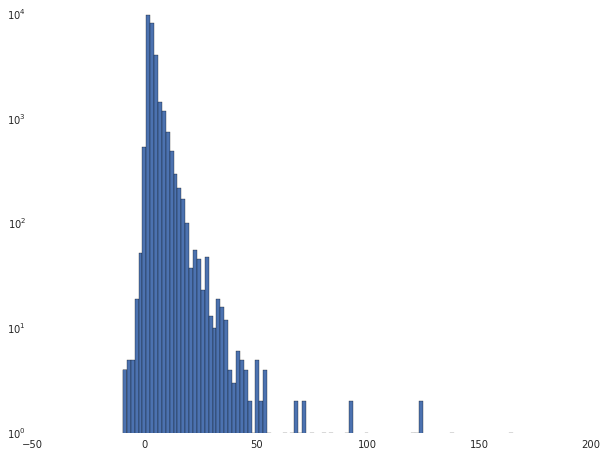

In [73]:
#trans_sample_df.purchaseamount.hist()
fig, ax = plt.subplots()
fig = trans_sample_df.purchaseamount.hist( ax=ax, bins=100)
#sns.kdeplot( trans_sample_df.purchaseamount)
ax.set_yscale('log')

#### Join datasets (still using trans_sample_df)

The transactions file can be joined to the history file by (id,chain). 

The history file can be joined to the offers file by (offer). 

The transactions file can be joined to the offers file by (category, brand, company). 

In [74]:
import sqlite3

In [23]:
print train_hist_df.shape
train_hist_df.head(5)

(160057, 7)


,id,chain,offer,market,repeattrips,repeater,offerdate
0,86246,205,1208251,34,5,t,2013-04-24
1,86252,205,1197502,34,16,t,2013-03-27
2,12682470,18,1197502,11,0,f,2013-03-28
3,12996040,15,1197502,9,0,f,2013-03-25
4,13089312,15,1204821,9,0,f,2013-04-01


In [24]:
print offers_df.shape
offers_df.head(5)

(37, 6)


,offer,category,quantity,company,offervalue,brand
0,1190530,9115,1,108500080,5.00,93904
1,1194044,9909,1,107127979,1.00,6732
2,1197502,3203,1,106414464,0.75,13474
3,1198271,5558,1,107120272,1.50,5072
4,1198272,5558,1,107120272,1.50,5072


In [25]:
pd.merge?

In [27]:
hist_offers_df = pd.merge( train_hist_df, offers_df, how='inner')

print hist_offers_df.shape
hist_offers_df.head(5)

(160057, 12)


,id,chain,offer,market,repeattrips,repeater,offerdate,category,quantity,company,offervalue,brand
0,86246,205,1208251,34,5,t,2013-04-24,2202,1,104460040,2,3718
1,15753725,17,1208251,4,0,f,2013-04-24,2202,1,104460040,2,3718
2,16535563,4,1208251,1,7,t,2013-04-27,2202,1,104460040,2,3718
3,18259179,3,1208251,2,0,f,2013-04-24,2202,1,104460040,2,3718
4,21024070,15,1208251,9,1,t,2013-04-23,2202,1,104460040,2,3718


In [28]:
hist_offers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160057 entries, 0 to 160056
Data columns (total 12 columns):
id             160057 non-null int64
chain          160057 non-null int64
offer          160057 non-null int64
market         160057 non-null int64
repeattrips    160057 non-null int64
repeater       160057 non-null object
offerdate      160057 non-null object
category       160057 non-null int64
quantity       160057 non-null int64
company        160057 non-null int64
offervalue     160057 non-null float64
brand          160057 non-null int64
dtypes: float64(1), int64(9), object(2)
memory usage: 15.9+ MB


#### Join hist_offers w/ trans-sample

In [30]:
print trans_sample_df.shape
trans_sample_df.head(3)

(27842, 11)


,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99


In [32]:
print hist_offers_df.shape
hist_offers_df.head(5)

(160057, 12)


,id,chain,offer,market,repeattrips,repeater,offerdate,category,quantity,company,offervalue,brand
0,86246,205,1208251,34,5,t,2013-04-24,2202,1,104460040,2,3718
1,15753725,17,1208251,4,0,f,2013-04-24,2202,1,104460040,2,3718
2,16535563,4,1208251,1,7,t,2013-04-27,2202,1,104460040,2,3718
3,18259179,3,1208251,2,0,f,2013-04-24,2202,1,104460040,2,3718
4,21024070,15,1208251,9,1,t,2013-04-23,2202,1,104460040,2,3718


In [35]:
df_sample = pd.merge( hist_offers_df, trans_sample_df, how='left')

print df_sample.shape
df_sample.head(5)

(160058, 18)


,id,chain,offer,market,repeattrips,repeater,offerdate,category,quantity,company,offervalue,brand,dept,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,1208251,34,5,t,2013-04-24,2202,1,104460040,2,3718,NaN,NaN,NaN,NaN,NaN,NaN
1,15753725,17,1208251,4,0,f,2013-04-24,2202,1,104460040,2,3718,NaN,NaN,NaN,NaN,NaN,NaN
2,16535563,4,1208251,1,7,t,2013-04-27,2202,1,104460040,2,3718,NaN,NaN,NaN,NaN,NaN,NaN
3,18259179,3,1208251,2,0,f,2013-04-24,2202,1,104460040,2,3718,NaN,NaN,NaN,NaN,NaN,NaN
4,21024070,15,1208251,9,1,t,2013-04-23,2202,1,104460040,2,3718,NaN,NaN,NaN,NaN,NaN,NaN


#### feature design
http://mlwave.com/predicting-repeat-buyers-vowpal-wabbit/

### Trying to load new data from local in chunks
Ref: "Python for Data Analysis" pg 177-ish

In [12]:
from pandas import Series

In [87]:
f = '/Users/rychughes/GA/AVS-Kaggle-Data/transactions-sample.csv'
f_zip = '/Users/rychughes/GA/AVS-Kaggle-Data/transactions.csv.gz'

In [88]:
head = pd.read_csv( f_zip, 
                   compression='gzip', nrows=5) 
head

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99
3,86246,205,25,2509,107996777,31373,2012-03-02,16,OZ,1,1.99
4,86246,205,55,5555,107684070,32094,2012-03-02,16,OZ,2,10.38


In [ ]:
# !gunzip -c '/Users/rychughes/GA/AVS-Kaggle-Data/transactions.csv.gz'

In [91]:
for skip_rows in range(0, 1000000, 100000):
    chunker = pd.read_csv( '/Users/rychughes/GA/AVS-Kaggle-Data/transactions.csv.gz', 
                    compression='gzip', 
                    nrows=100000,
                     skiprows=skip_rows) 
    

100000
100000
100000
100000
100000
100000
100000
100000
100000
100000


In [20]:
def read_in_chunks( file_object, chunk_size=1024):
    'Lazy function (generator) to read a file piece by peice'
    'Default chunk size 1k'
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

In [26]:
transaction_sample_file = open('/Users/rychughes/GA/AVS-Kaggle-Data/transactions-sample.csv')  

In [31]:
for chunk in read_in_chunks( transaction_sample_file):
    tot.add(piece)

ValueError: operands could not be broadcast together with shapes (0,) (1000,11) 

In [64]:
new_array=[]
with open('/Users/rychughes/GA/AVS-Kaggle-Data/transactions-sample.csv') as f:
    for line in f:
        new_array.append( line)

In [65]:
new_array

['"id","chain","dept","category","company","brand","date","productsize","productmeasure","purchasequantity","purchaseamount"\r\n',
 '86246,205,7,707,1078778070,12564,"2012-03-02",12,"OZ",1,7.59\r\n',
 '86246,205,63,6319,107654575,17876,"2012-03-02",64,"OZ",1,1.59\r\n',
 '86246,205,97,9753,1022027929,0,"2012-03-02",1,"CT",1,5.99\r\n',
 '86246,205,25,2509,107996777,31373,"2012-03-02",16,"OZ",1,1.99\r\n',
 '86246,205,55,5555,107684070,32094,"2012-03-02",16,"OZ",2,10.38\r\n',
 '86246,205,97,9753,1021015020,0,"2012-03-02",1,"CT",1,7.8\r\n',
 '86246,205,99,9909,104538848,15343,"2012-03-02",16,"OZ",1,2.49\r\n',
 '86246,205,59,5907,102900020,2012,"2012-03-02",16,"OZ",1,1.39\r\n',
 '86246,205,9,921,101128414,9209,"2012-03-02",4,"OZ",2,1.5\r\n',
 '86246,205,73,7344,1068142161,20285,"2012-03-02",8,"CT",1,5.79\r\n',
 '86246,205,41,4107,104113040,28204,"2012-03-02",14.5,"OZ",1,0.59\r\n',
 '86246,205,21,2106,105100050,27873,"2012-03-02",64,"OZ",1,3.29\r\n',
 '86246,205,8,814,102840020,18584,"2012-03

In [66]:
new_df = pd.DataFrame?

In [70]:
new_df = pd.DataFrame(new_array)
new_df.head(3)

,0
0,"""id"",""chain"",""dept"",""category"",""company"",""bran..."
1,"86246,205,7,707,1078778070,12564,""2012-03-02"",..."
2,"86246,205,63,6319,107654575,17876,""2012-03-02""..."


In [77]:
new_df[0][0][1:3]

'id'

In [82]:
new_df_2 = pd.concat([Series(row['var1'], row['var2'].split(','))
                      for _, row in new_df.iterrows()]).reset_index()

KeyError: 'var1'

In [71]:
#new_df = new_df[0].str.split(',').apply(Series,1).stack()
#new_df

In [72]:
test_df = pd.DataFrame()

In [73]:
with open('/Users/rychughes/GA/AVS-Kaggle-Data/transactions-sample.csv') as f:
    for line in f:
        test_df.append(line)

TypeError: cannot concatenate a non-NDFrame object

In [57]:
import StringIO
df = pd.read_csv( StringIO(new_array), header=1, delimiter=',')

TypeError: 'module' object is not callable

In [40]:
new_df_parsed = pd.read_table(new_df, sep=',')
#pd.DataFrame([x.split(',') for x in new_df])
new_df_parsed

IOError: Expected file path name or file-like object, got <class 'pandas.core.frame.DataFrame'> type

In [ ]:
new_df

In [19]:
tot = Series([])
for chunk in chunker:
    tot = tot.add( chunk['key'].value_counts(), fill_value=0)

tot = tot.order(ascendending=False)

KeyError: 'key'